# Versuch 1: Kalibrierung und Einsatz eines Infrarot-Entfernungsmessers

In [1]:
# import
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## 1. Ermittlung der Kennlinie des Abstandssensors

In [2]:
# setup
distances = [
    10,
    13.5,
    17,
    20.5,
    24,
    27.5,
    31,
    34.5,
    38,
    41.5,
    45,
    48.5,
    52,
    55.5,
    59,
    62.5,
    66,
    69.5,
    73,
    76.5,
    80,
]
mean_voltages = [
    1.4,
    1.223,
    1.067,
    0.934,
    0.856,
    0.8001,
    0.743,
    0.704,
    0.627,
    0.585,
    0.563,
    0.540,
    0.522,
    0.490,
    0.419,
    0.426,
    0.425,
    0.408,
    0.384,
    0.369,
    0.369,
]

In [3]:
# Function to read the data from the csv
def read_data_from_file(path: str):
    measurement_data = np.genfromtxt(
        path,
        delimiter=";",
        skip_header=1003,
        usecols=(1),
        converters={1: lambda s: float(s.decode("utf-8").replace(",", "."))},
    )

    return measurement_data

In [4]:
# read data from measurements
data = []
for distance_idx, distance_value in enumerate(distances):
    measurement_data = read_data_from_file(
        f"./messung/kennlinie/abstand-{str(distance_value)}.csv"
    )

    data.append(
        [distance_value, np.mean(measurement_data), np.std(measurement_data, ddof=1)]
    )

# Create dataframe
df = pd.DataFrame(data, columns=["Distance", "Mean", "Std"])

FileNotFoundError: ./messung/kennlinie/abstand-10.csv not found.

In [5]:
df

,Distance,Mean,Std
0,10.0,1.401714,0.020694
1,13.5,1.223408,0.020261
2,17.0,1.066845,0.023423
3,20.5,0.939753,0.020401
4,24.0,0.856340,0.023498
5,27.5,0.800428,0.020668
6,31.0,0.742600,0.021940
7,34.5,0.704404,0.020035
8,38.0,0.627323,0.024381
9,41.5,0.584996,0.025384


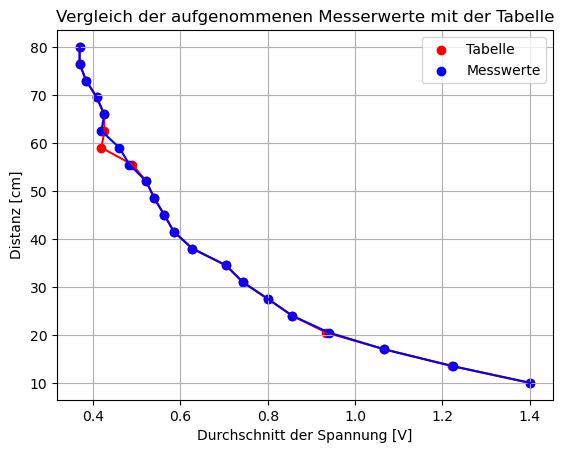

In [6]:
# Plot mean values
plt.scatter(mean_voltages, distances, color="r", label="Tabelle")
plt.plot(mean_voltages, distances, color="r")
plt.scatter(df["Mean"], distances, color="b", label="Messwerte")
plt.plot(df["Mean"], distances, color="b")
plt.title("Vergleich der aufgenommenen Messerwerte mit der Tabelle")
plt.xlabel("Durchschnitt der Spannung [V]")
plt.ylabel("Distanz [cm]")
plt.legend()
plt.grid(True)
plt.show()

## 2. Modellierung der Kennlinie durch lineare Regression

Ansatzfunktion für eine lineare Regression eines nicht-linearen Zusammenhangs:
$$
ln(y) = \alpha \cdot ln(x) + \beta
$$

Die Rückrechnung auf den ursprünglichen nicht-linearen Zusammenhang:
$$
y = e^ \beta \cdot x ^ \alpha
$$

In [7]:
x = df["Mean"]
y = df["Distance"]

log_x = np.log(x)
log_y = np.log(y)

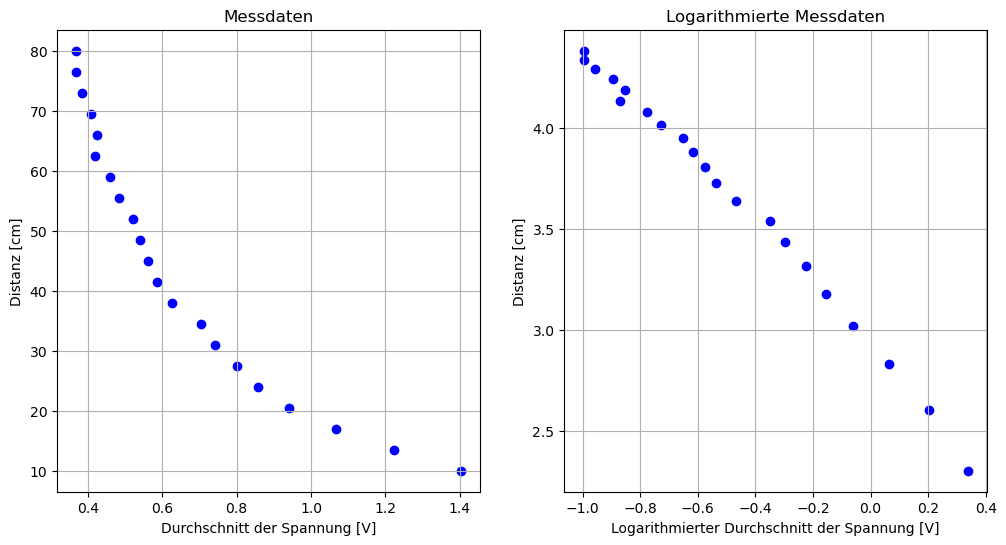

In [8]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].set_title("Messdaten")
ax[0].scatter(x, y, color="b")
ax[0].set_xlabel("Durchschnitt der Spannung [V]")
ax[0].set_ylabel("Distanz [cm]")
ax[0].grid(True)

ax[1].set_title("Logarithmierte Messdaten")
ax[1].scatter(log_x, log_y, color="b")
ax[1].set_xlabel("Logarithmierter Durchschnitt der Spannung [V]")
ax[1].set_ylabel("Distanz [cm]")
ax[1].grid(True)

plt.show()

### Lineare Regression - Herleitung des linearen Gleichungsystems

Minimierungsfunktion:
$$\begin{aligned}
    & \text{min} \sum_{i=1}^{n}(\ln(y_i) - (\beta + \alpha \cdot \ln(x_i)))^2 \\
    & \frac{df}{d\alpha} = 2 \cdot \sum_{i=1}^{n}-\ln(x_i) \cdot (\ln(y_i) - (\beta + \alpha \cdot \ln(x_i))) = 0 \longleftrightarrow  \alpha \cdot \sum_{i=1}^{n}{\ln(x_i)^2} + \beta \cdot \sum_{i=1}^{n}{\ln(x_i)} = \sum_{i=1}^{n}{\ln(x_i)}{\ln(y_i)}\\
    & \frac{df}{d\beta} = 2 \cdot \sum_{i=1}^{n} (-1) \cdot (\ln(y_i) - (\beta + \alpha \cdot \ln(x_i))) = 0 \longleftrightarrow \alpha \cdot \sum_{i=1}^{n}{\ln(x_i)} + \beta \cdot n =     \sum_{i=1}^{n}{\ln(y_i)}\\
\end{aligned}$$

Resultierendes lineares Gleichungsystem:
$$
\begin{pmatrix}
    \sum_{i=1}^{n} \ln{x_i} \cdot \ln{y_i} & \sum_{i=1}^{n}(\ln(x_i)) \\
    \sum_{i=1}^{n}(\ln(x_i)) & n \\
\end{pmatrix}
\begin{pmatrix}
    \alpha \\
    \beta \\
\end{pmatrix} = 
\begin{pmatrix}
    \sum_{i=1}^{n} \ln{x_i} \cdot \ln{y_i} \\
    \sum_{i=1}^{n}(\ln(y_i)) \\
\end{pmatrix}    
$$

### Auflösen des linearen Gleichungsystems nach **a** und **b**

$$
a = \frac{{\text{{n}} \cdot \sum_{i=1}^{n} \ln{x_i} \cdot \ln{y_i} \cdot - \sum_{i=1}^{n} \ln{x_i} \cdot \sum_{i=1}^{n} \ln{y_i}}}{{\text{{n}} \cdot \sum_{i=1}^{n} \ln{x_i} \cdot \ln{x_i} - (\sum_{i=1}^{n} \ln{x_i})^2}}
$$

$$
b = \frac{{-\sum_{i=1}^{n} a \cdot \ln{x_i} + \sum_{i=1}^{n} \ln{y_i}}}{{\text{{n}}}}
$$


In [9]:
a = (np.dot(log_x, log_y) * len(log_y) - np.sum(log_x) * np.sum(log_y)) / (
    np.dot(log_x, log_x) * len(log_y) - np.sum(log_x) ** 2
)
b = (-a * np.sum(log_x) + np.sum(log_y)) / len(log_y)

print("a =", a)
print("b =", b)

a = -1.4763502063990968
b = 2.930579488316986


In [10]:
def characteristic_func(value):
    return np.exp(b) * pow(value, a)


def regression_func(value):
    return a * value + b


def get_y_for_x_array(x_values, func):
    y_values = np.zeros(len(x_values))
    for i in range(len(x_values)):
        y_values[i] = func(x_values[i])
    return y_values

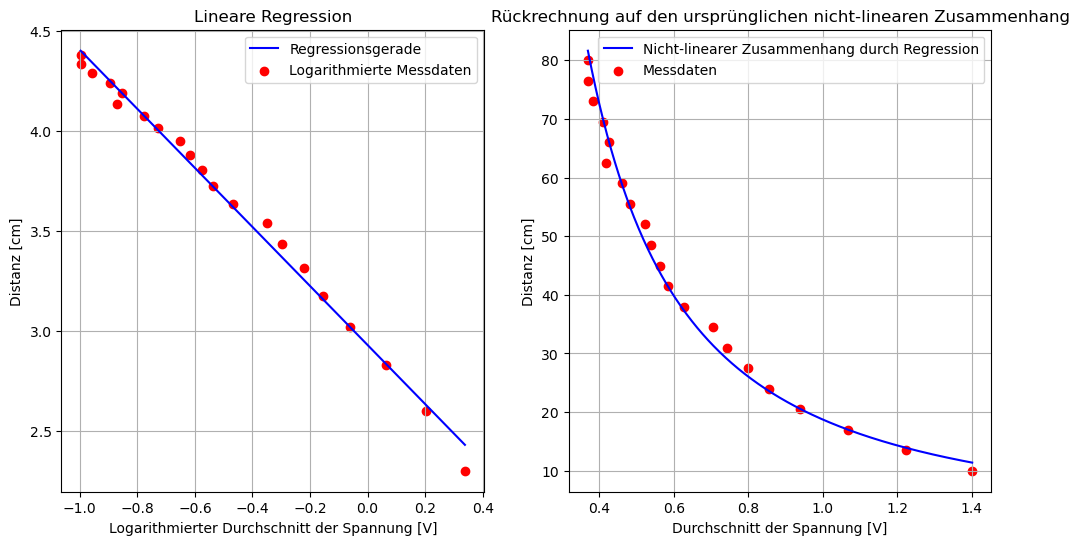

In [11]:
x_values = np.linspace(np.min(df["Mean"]), np.max(df["Mean"]), 500)
y_charackteristic = get_y_for_x_array(x_values, characteristic_func)

y_regression = get_y_for_x_array(np.log(x_values), regression_func)


fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].plot(
    np.log(x_values),
    y_regression,
    label="Regressionsgerade",
    color="b",
)
ax[0].scatter(log_x, log_y, label="Logarithmierte Messdaten", color="r")
ax[0].set_xlabel("Logarithmierter Durchschnitt der Spannung [V]")
ax[0].set_ylabel("Distanz [cm]")
ax[0].set_title("Lineare Regression")
ax[0].grid(True)
ax[0].legend()
ax[0].plot()

ax[1].plot(
    x_values,
    y_charackteristic,
    label="Nicht-linearer Zusammenhang durch Regression",
    color="b",
)
ax[1].scatter(x, y, label="Messdaten", color="r")
ax[1].set_xlabel("Durchschnitt der Spannung [V]")
ax[1].set_ylabel("Distanz [cm]")
ax[1].set_title("Rückrechnung auf den ursprünglichen nicht-linearen Zusammenhang")
ax[1].grid(True)
ax[1].legend()

plt.show()

## 3. Flächenmessung mit Fehlerrechnung

In [12]:
# read data from length measurements
measurement_data_height = read_data_from_file("./messung/papier/abstand-a4-höhe.csv")
measurement_data_width = read_data_from_file("./messung/papier/abstand-a4-breite.csv")


measurement_data_height_stats = pd.DataFrame(
    [[np.mean(measurement_data_height), np.std(measurement_data_height, ddof=1)]],
    columns=["mean", "std"],
)

### Messergebnis der Spannungsmessung für die Länge des DIN A4

Angabe des Messergebnisses:
$$
x = \overline{x} \pm t \cdot \sigma
$$

In [13]:
t_6826 = 1.0  # Faktor t bei Sicherheit P = 68,26%
t_95 = 1.96  # Faktor t bei Sicherheit P = 95%

delta_h_t_6826 = measurement_data_height_stats["std"][0] * t_6826
delta_h_t_95 = measurement_data_height_stats["std"][0] * t_95

print(
    r"Vertrauensbereich 68.26%%: x = %f +- %f [V]"
    % (measurement_data_height_stats["mean"][0], delta_h_t_6826)
)
print(
    r"Vertrauensbereich 95%%: x = %f +- %f [V]"
    % (measurement_data_height_stats["mean"][0], delta_h_t_95)
)

Vertrauensbereich 68.26%: x = 0.760092 +- 0.022529 [V]
Vertrauensbereich 95%: x = 0.760092 +- 0.044156 [V]


### Messergebnis für die Länge des DIN A4 aus der bestimmten Kennlinie des Sensors

$$
\Delta y = \frac{{\partial f}}{{\partial x}} \cdot \Delta x
$$
$$
\Delta l = a \cdot e ^ b \cdot x ^ {a-1} \cdot \Delta x
$$

In [14]:
def characteristic_func_derivate(value):
    return a * np.exp(b) * pow(value, a - 1)

In [15]:
delta_height = (
    characteristic_func_derivate(measurement_data_height_stats["mean"][0])
    * measurement_data_height_stats["std"][0]
)

print(
    "Länge l = %f +- %f [cm]"
    % (characteristic_func(measurement_data_height_stats["mean"][0]), -delta_height)
)

Länge l = 28.094281 +- 1.229354 [cm]


### Messergebnis für die Fläche des DIN A4

In [16]:
measurement_data_width_stats = pd.DataFrame(
    [[np.mean(measurement_data_width), np.std(measurement_data_width, ddof=1)]],
    columns=["mean", "std"],
)

delta_width = (
    characteristic_func_derivate(measurement_data_width_stats["mean"][0])
    * measurement_data_width_stats["std"][0]
)

print(
    "Breite b = %f +- %f [cm]"
    % (characteristic_func(measurement_data_width_stats["mean"][0]), -delta_width)
)

Breite b = 20.655660 +- 0.650722 [cm]


$$
fläche = f(l, b) = l \cdot b
$$
$$
\Delta fläche = \sqrt{{(\frac{{\partial f}}{{\partial l}} \cdot \Delta l)} ^ 2 + {(\frac{{\partial f}}{{\partial b}} \cdot \Delta b)} ^ 2}
$$
$$
\frac{{\partial f}}{{\partial l}} = b
$$
$$
\frac{{\partial f}}{{\partial b}} = l
$$

In [17]:
area = characteristic_func(
    measurement_data_height_stats["mean"][0]
) * characteristic_func(measurement_data_width_stats["mean"][0])

delta_area = np.sqrt(
    (measurement_data_width_stats["mean"][0] * delta_height) ** 2
    + (measurement_data_height_stats["mean"][0] * delta_width) ** 2
)

print("Fläche = %f +- %f [cm^2]" % (area, delta_area))

Fläche = 580.305900 +- 1.252643 [cm^2]
